In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import sys, os

os.chdir('/ix/djishnu/alw399')

In [5]:
import celloracle as co
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180

sc.settings.set_figure_params(dpi=50, facecolor="white")

In [6]:
adata = sc.read_h5ad('SpaceOracle/data/slideseq/adata_train_new.h5ad')
del adata.layers['imputed_count']
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'normalized_count', 'raw_count'

### CellOracle

In [ ]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(adata, groups='clusters', neighbors_key='neighbors')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

In [ ]:
oracle = co.Oracle()
# adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="rctd_cluster",
                                   embedding_name="X_draw_graph_fr")

In [ ]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [ ]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

In [ ]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=1)

In [ ]:
annot = 'rctd_cluster'

adata = oracle.adata
x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1] * -1

adata = adata.copy()
adata.obsm['spatial'] = np.vstack([x, y]).T

sc.pl.spatial(adata, color=[goi, annot], layer='normalized_count', use_raw=False, cmap='viridis', spot_size=50)
sc.pl.spatial(adata, color=[goi, annot], layer='imputed_count', use_raw=False, cmap='viridis', spot_size=50)


In [ ]:
co_imputed_count = adata.layers['imputed_count'].copy()
print(co_imputed_count)

### BalancedKNN

In [ ]:
del adata.layers['imputed_count']

In [ ]:
sys.path.append('/ix/djishnu/alw399/SpaceOracle/src')
from spaceoracle.oracles import SpaceOracle

In [ ]:
so = SpaceOracle(
    adata=adata,
    save_dir='/ix/djishnu/shared/djishnu_kor11/models',
    annot='rctd_cluster'
)

In [ ]:
so_imputed_count = so.adata.layers['imputed_count']
so_imputed_count.shape

In [ ]:
goi = 'Il2ra'
annot = 'rctd_cluster'

adata = so.adata

x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1] * -1

adata = adata.copy()
adata.obsm['spatial'] = np.vstack([x, y]).T
sc.pl.spatial(adata, color=[goi, annot], layer='imputed_count', use_raw=False, cmap='viridis', spot_size=50)

In [ ]:
so.adata.layers['imputed_count']

In [ ]:
so.adata.layers['normalized_count'].toarray()

### MAGIC

In [38]:
import magic

magic_operator = magic.MAGIC()
X = adata.layers['normalized_count']
X = pd.DataFrame(X, columns=adata.var_names, index=adata.obs_names)

In [ ]:
'Prdm1' in adata.var_names

Calculating MAGIC...
  Running MAGIC on 11567 cells and 3020 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.64 seconds.
    Calculating KNN search...
    Calculated KNN search in 9.14 seconds.
    Calculating affinities...
    Calculated affinities in 9.08 seconds.
  Calculated graph and diffusion operator in 19.89 seconds.
  Calculating imputation...
  Calculated imputation in 1.28 seconds.
Calculated MAGIC in 21.19 seconds.


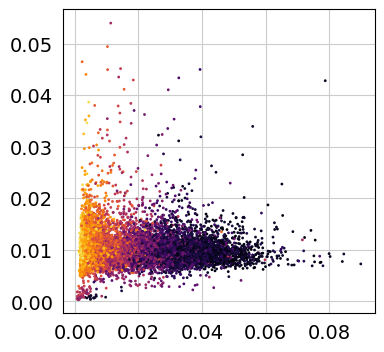

In [39]:
X_magic = magic_operator.fit_transform(X, genes='all_genes')
plt.scatter(X_magic['Il2ra'], X_magic['Il2'], c=X_magic['Cd74'], s=1, cmap='inferno')
plt.show()

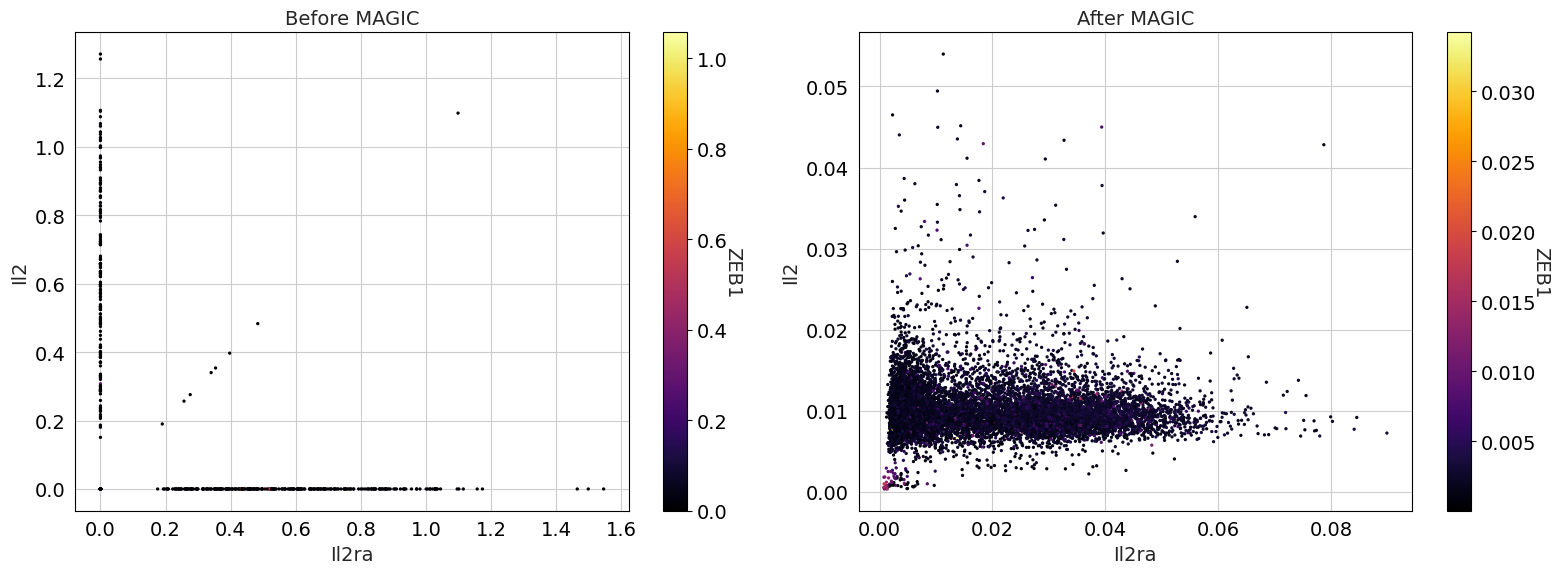

In [ ]:
import scprep

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=X['Il2ra'], y=X['Il2'], c=X['Prdm1'],  ax=ax1,
                    xlabel='Il2ra', ylabel='Il2', legend_title="Prdm1", title='Before MAGIC')

scprep.plot.scatter(x=X_magic['Il2ra'], y=X_magic['Il2'], c=X_magic['Prdm1'], ax=ax2,
                    xlabel='Il2ra', ylabel='Il2', legend_title="Prdm1", title='After MAGIC')

plt.tight_layout()
plt.show()

In [41]:
adata.layers['imputed_count'] = X_magic

In [57]:
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'normalized_count', 'raw_count', 'imputed_count'

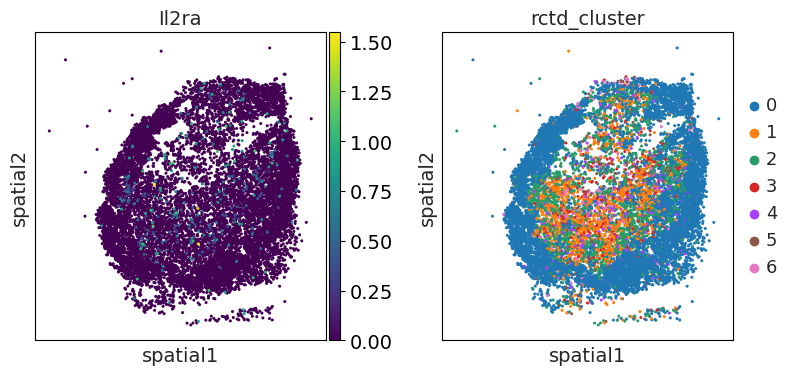

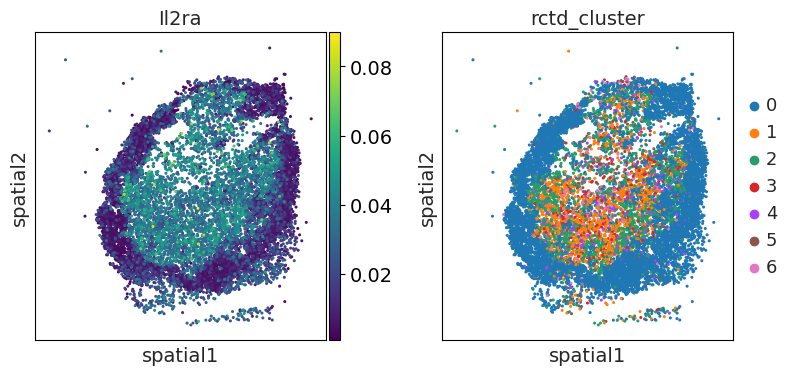

In [42]:
annot = 'rctd_cluster'

goi = 'Il2ra'
x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1] * -1

adata = adata.copy()
adata.obsm['spatial'] = np.vstack([x, y]).T

sc.pl.spatial(adata, color=[goi, annot], layer='normalized_count', use_raw=False, cmap='viridis', spot_size=50)
sc.pl.spatial(adata, color=[goi, annot], layer='imputed_count', use_raw=False, cmap='viridis', spot_size=50)


### DCA

In [6]:
adata.X = adata.layers['raw_count']
sc.external.pp.dca(adata)

ImportError: Please install dca package (>= 0.2.1) via `pip install dca`

In [ ]:
adata

In [ ]:
sc.pl.spatial(adata, color=[goi, annot], layer='normalized_count', use_raw=False, cmap='viridis', spot_size=50)
sc.pl.spatial(adata, color=[goi, annot], layer='dca_imputed', use_raw=False, cmap='viridis', spot_size=50)

In [ ]:
adata.layers['raw_count'].max()

### knn-smoothing

In [70]:
sys.path.append('SpaceOracle/src/spaceoracle/tools')

from knn_smooth import knn_smoothing

d = 10          # n pcs default 10
dither = 0.03   # default 0.03 
k = 32          # number of neighbors 

matrix = adata.layers['raw_count'].T 
p, n = matrix.shape
print('The expression matrix contains %d genes and %d cells.' % (p, n))

S = knn_smoothing(matrix, k, d=d, dither=dither, seed=1334)

The expression matrix contains 3020 genes and 11567 cells.
Performing kNN-smoothing v2.1 with k=32, d=10, and dither=0.030...
Step 1/5: Smooth using k=2
	PCA took 0.6 s.
	The fraction of variance explained by the top 10 PCs is 13.5 %.
	Calculating pair-wise distance matrix took 0.5 s.


/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Calculating the smoothed expression matrix took 1330.2 s.
Step 2/5: Smooth using k=4
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 15.3 %.
	Calculating pair-wise distance matrix took 0.4 s.
	Calculating the smoothed expression matrix took 37.5 s.
Step 3/5: Smooth using k=8
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 17.8 %.
	Calculating pair-wise distance matrix took 0.4 s.
	Calculating the smoothed expression matrix took 37.4 s.
Step 4/5: Smooth using k=16
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 21.3 %.
	Calculating pair-wise distance matrix took 0.4 s.
	Calculating the smoothed expression matrix took 37.4 s.
Step 5/5: Smooth using k=32
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 26.4 %.
	Calculating pair-wise distance matrix took 0.4 s.
	Calculating the smoothed expression matrix took 37.5 s.
kNN-smoothing finished in 1485.3 s.


In [ ]:
adata.layers['knnsmooth_count'] = S.T

(3020, 11567)

### Test oracles.py

In [ ]:
import sys 
sys.path.append('../src')

from spaceoracle.oracles import SpaceOracle

so = SpaceOracle(
    adata=adata,
    save_dir='/ix/djishnu/shared/djishnu_kor11/models',
    annot='rctd_cluster', 
)